In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
import pickle
from scipy.optimize import curve_fit
from lpu3dnet.post_process.kr_process import *
from sklearn.metrics import mean_squared_error, mean_absolute_error


root_dir = 'db'
ct_idx = 1
vol_dim = 4
with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
    # Deserialize the data from the file and assign it to a variable
    sim_results = pickle.load(file)


def truncated_kr(df,corey_fit):
    swir = corey_fit.swirr
    sorg = corey_fit.sor

    # find largest krw and krnw
    krw_max = df['krw'].max()
    krnw_max = df['krnw'].max()
    # truncated df based on the krw and krnw
    df = df[ (df['krw']<krw_max) & (df['krnw']<krnw_max) ]
    # truncated kr based on the swir and sorg
    # make sure sw in the range of swir and 1-sorg
    # df = df[(df['sw']>=swir) & (df['sw']<=1-sorg)]
    return df

def calculate_error_metrics(predictions, true_value, metric='mse'):
    """
    Calculate error metrics for a list of predictions against a true value.

    Args:
    predictions (list): List of prediction values.
    true_value (float): The true value to compare against.
    metric (str): Specify 'mse' for Mean Squared Error or 'mae' for Mean Absolute Error.

    Returns:
    float: The calculated error metric.
    """
    # Repeat the true value to match the length of predictions
    true_values = [true_value] * len(predictions)
    
    if metric == 'mse':
        return mean_squared_error(true_values, predictions)
    elif metric == 'mae':
        return mean_absolute_error(true_values, predictions)
    else:
        raise ValueError("Metric must be 'mse' or 'mae'")


def plot_ensemble_results(sim_results, sample_idx, metric='mse'):
    # df_all_compare = aggregate_kr(sim_results['compare'])
    num_pred = len(sim_results[sample_idx]['generate'])
    num_compare = len(sim_results['compare'])

    prediction = {'data':[],'par':[]}
    compare = {'data':[],'par':[]}


    for i in range(num_pred):
        if sim_results[sample_idx]['generate'][i]:
            df_pred = convert_dict_to_pd(sim_results[sample_idx]['generate'][i])
            corey_fit = Corey_fit(df_pred)
            kr_avg_pred,par,criteria = corey_fit.generate_kr_data()
            if criteria:
                prediction['data'].append(truncated_kr(kr_avg_pred,corey_fit))
                prediction['par'].append(par)
        


    for i in range(num_compare):
        if sim_results['compare'][i]:
            df_compare = convert_dict_to_pd(sim_results['compare'][i])
            corey_fit = Corey_fit(df_compare)
            kr_avg_compare,par,criteria = corey_fit.generate_kr_data()
            if criteria:
                compare['data'].append(truncated_kr(kr_avg_compare,corey_fit))
                compare['par'].append(par)

    df_real = sim_results[sample_idx]['original']
    if not df_real:
        return
    # fit the real data
    df_real = convert_dict_to_pd(df_real)
    corey_fit = Corey_fit(df_real)
    kr_real,par_real,criteria = corey_fit.generate_kr_data()

    if not criteria:
        return

    kr_real = truncated_kr(kr_real,corey_fit)


    prediction_data = prediction['data']
    compare_data = compare['data']
    num_samples = min(len(prediction_data), len(compare_data))
    irr_sw_pred = [x[0][1] for x in prediction['par']][:num_samples]
    irr_sw_compare = [x[0][1] for x in compare['par']][:num_samples]
    res_gas_pred = [x[1][1] for x in prediction['par']][:num_samples]
    res_gas_compare = [x[1][1] for x in compare['par']][:num_samples]


    from sklearn.metrics import mean_squared_error, mean_absolute_error
    # calculate error
    err_mse_swir_pred = calculate_error_metrics(
        irr_sw_pred,
        par_real[0][1], metric='mse'
        )
    err_mse_swir_compare = calculate_error_metrics(
        irr_sw_compare,
        par_real[0][1], metric='mse'
        )

    print(err_mse_swir_pred, err_mse_swir_compare)



    f = plt.figure(figsize=(10, 6))
    for i in range(len(prediction_data)):
        plt.plot(
            prediction_data[i]['sw'],
            prediction_data[i]['krnw'], 'r-',linewidth=2,alpha=0.4
            )
    
    for j in range(len(compare_data)):
        plt.plot(compare_data[j]['sw'],
                compare_data[j]['krnw'],
                'y*',
                linewidth=1,alpha=0.4
                )
        
    plt.title(f'Sample idx {sample_idx}')
    plt.xlabel('Water Saturation (Sw)')
    plt.plot(kr_real['sw'], kr_real['krnw'], color='blue',linewidth=5, label='Actual Data')
    plt.plot(df_real['sw'], df_real['kr_air'], color='blue', label='Actual Data')
    plt.grid(True)

    plt.show()


    f = plt.figure(figsize=(10, 6))
    for i in range(len(prediction_data)):
        plt.plot(
            prediction_data[i]['sw'],
            prediction_data[i]['krw'], 'r-',linewidth=2,alpha=0.4
            )
    
    for j in range(len(compare_data)):
        plt.plot(compare_data[j]['sw'],
                compare_data[j]['krw'],
                'y*',
                linewidth=1,alpha=0.4
                )
    plt.title(f'Sample idx {sample_idx}')
    plt.xlabel('Water Saturation (Sw)')
    plt.plot(kr_real['sw'], kr_real['krw'], color='blue',linewidth=5, label='Actual Data')
    plt.plot(df_real['sw'], df_real['kr_water'], color='blue', label='Actual Data')
    plt.grid(True)

    plt.show()


    # f = plt.figure(figsize=(10, 6))

    # # Plot histograms for both sets of predictions
    # plt.hist(irr_sw_pred, bins=20, alpha=0.5, label='Predictions')
    # plt.hist(irr_sw_compare[:num_samples], bins=20, alpha=0.5, label='Compare')

    # # Plot a vertical line for the true value
    # plt.axvline(x=par_real[0][1], color='r', linestyle='dashed', linewidth=2, label='True Value')

    # # Adding labels and title
    # plt.xlabel('Prediction Values')
    # plt.ylabel('Frequency')
    # plt.title('Histogram of Predictions with True Value Line')
    # plt.legend()
    # # Show the plot
    # plt.show()


ct_idx 1
------------------------------------------------------------
0.11451718961314261 0.12679081059489944


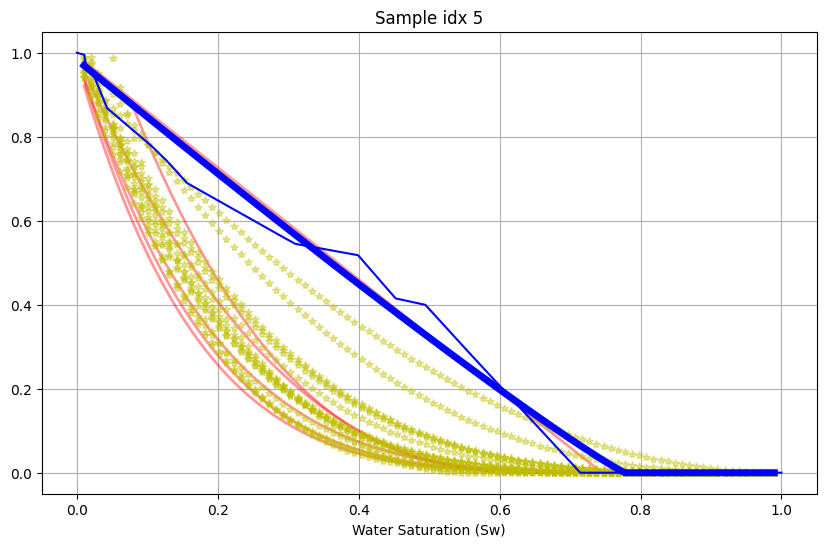

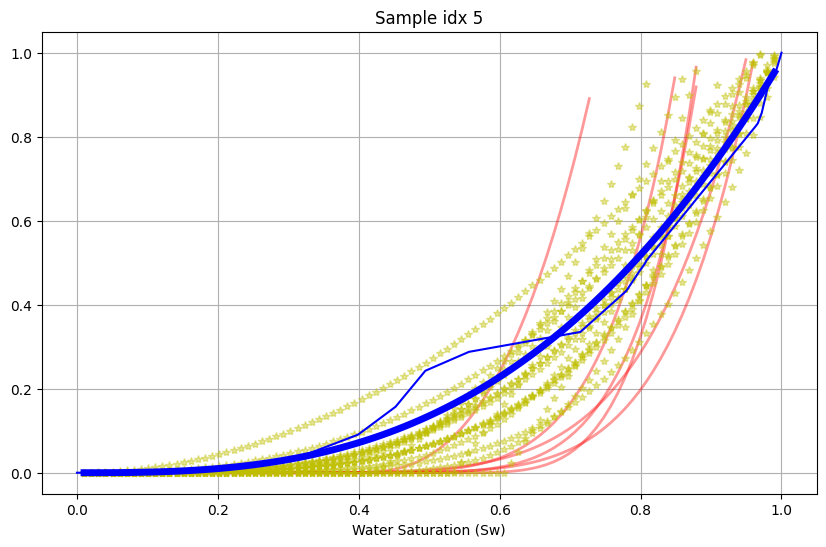

0.17442256841171946 0.13354144583074376


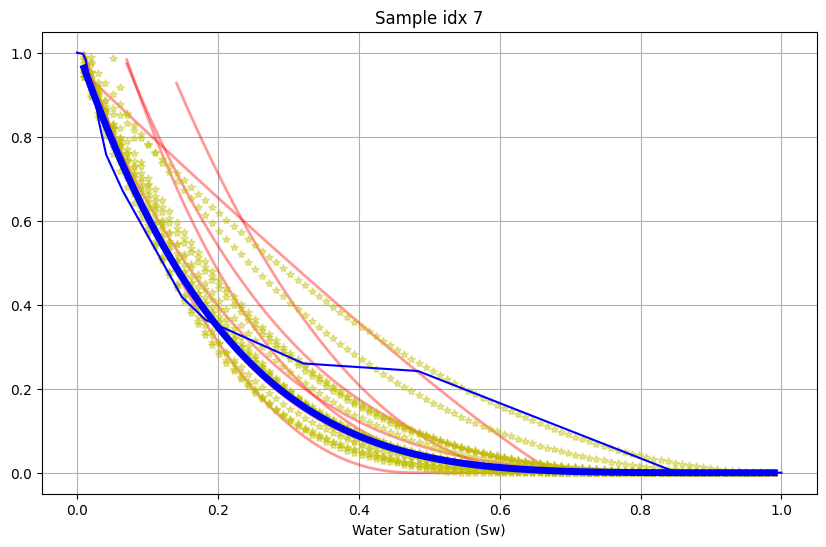

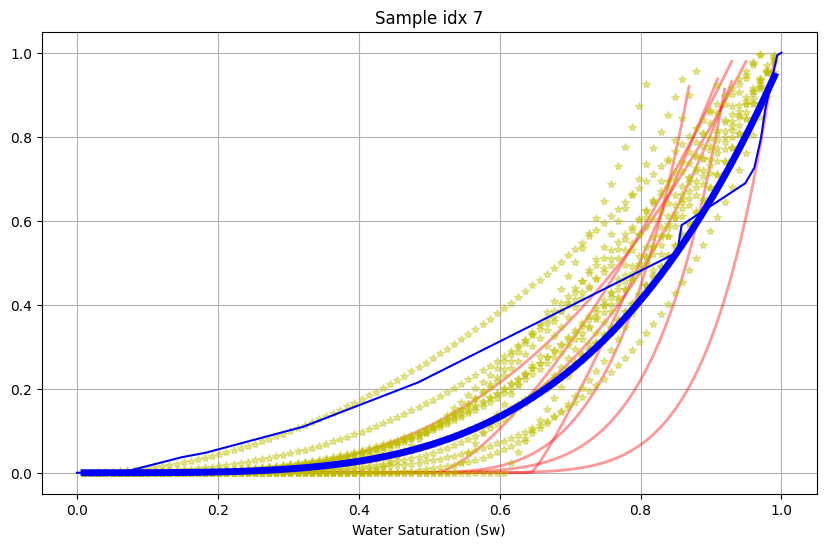

0.10881036100710303 0.0934790120815206


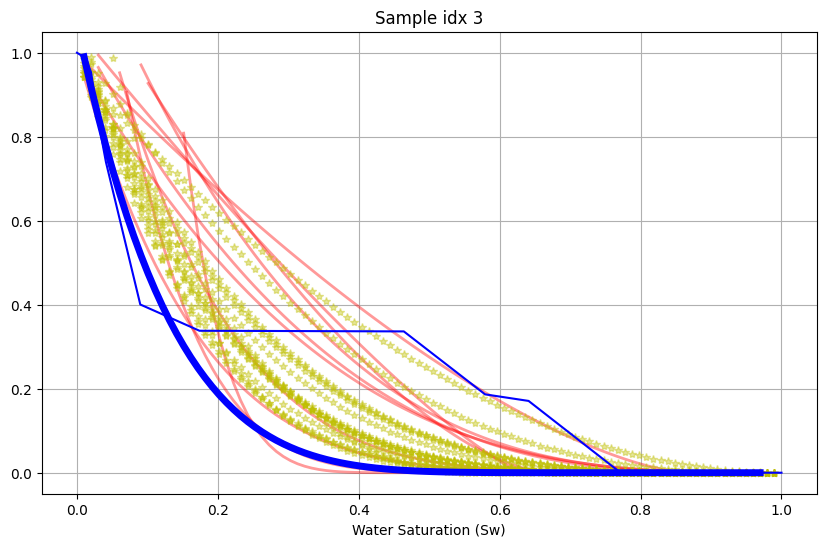

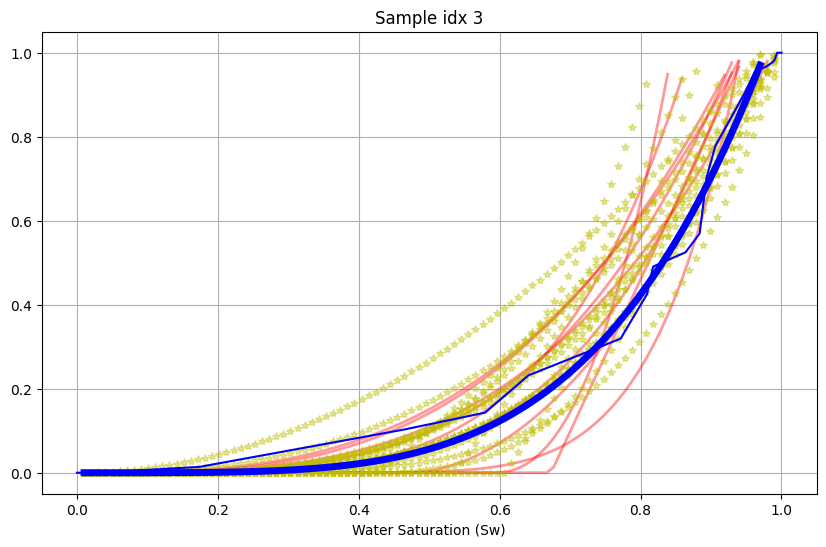

0.06822426293997935 0.06677852216326187


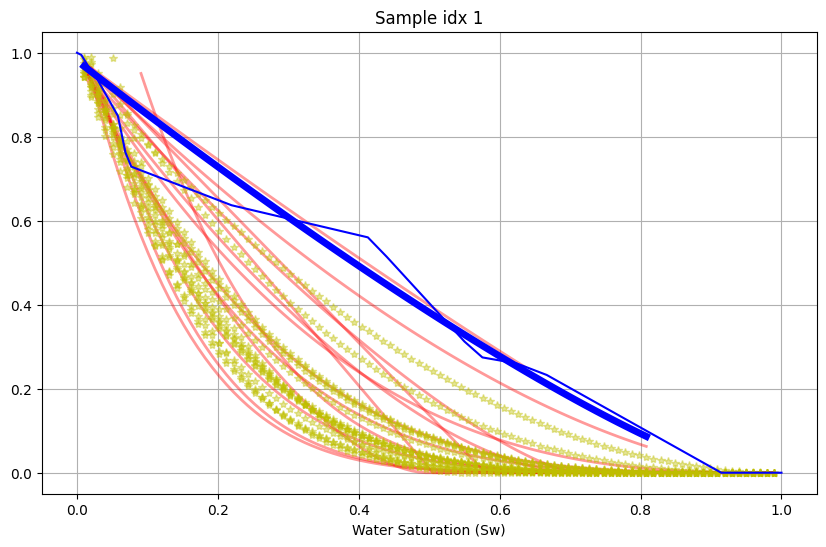

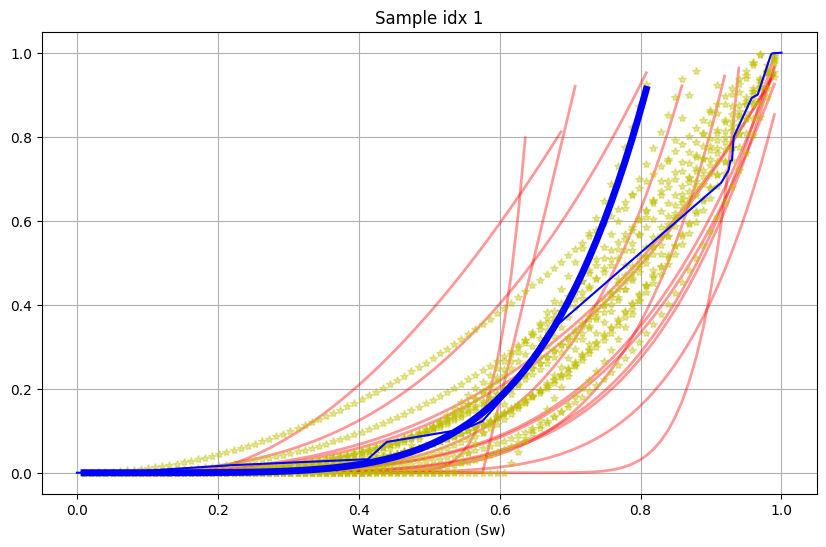

ct_idx 2
------------------------------------------------------------
0.13458975990548327 0.07667676247775024


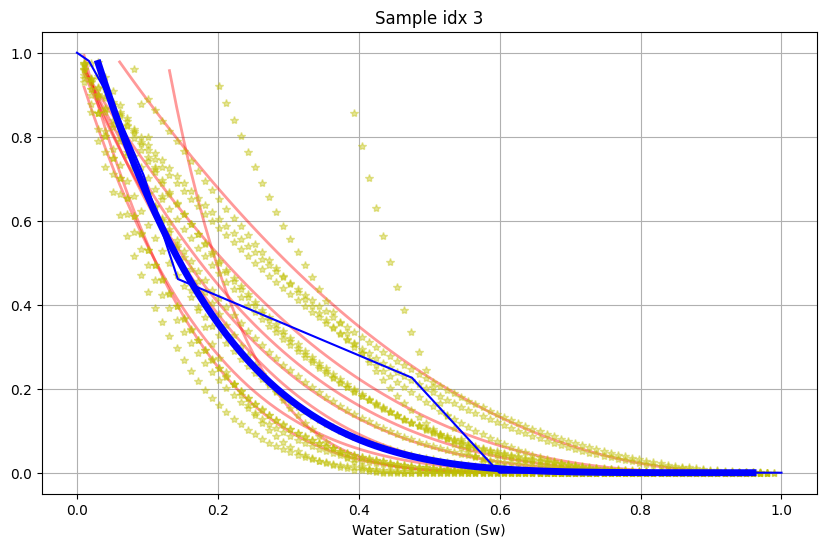

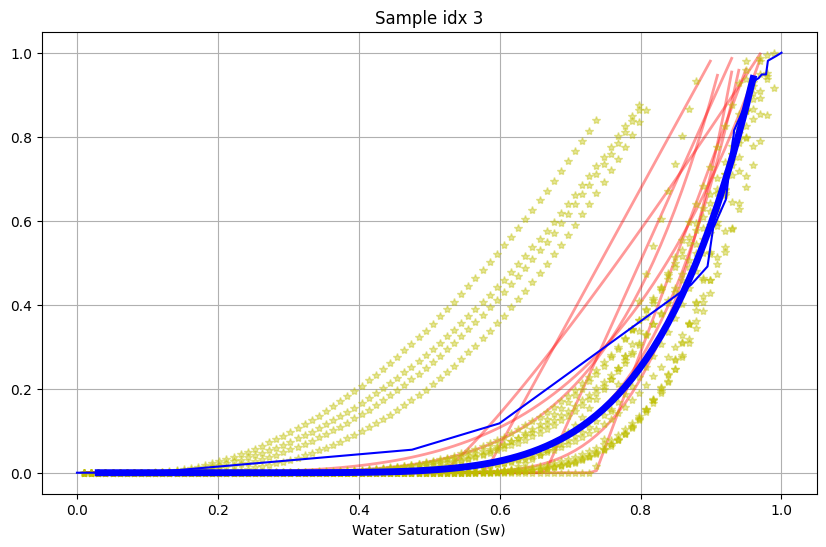

0.15411738894237936 0.06912487419645238


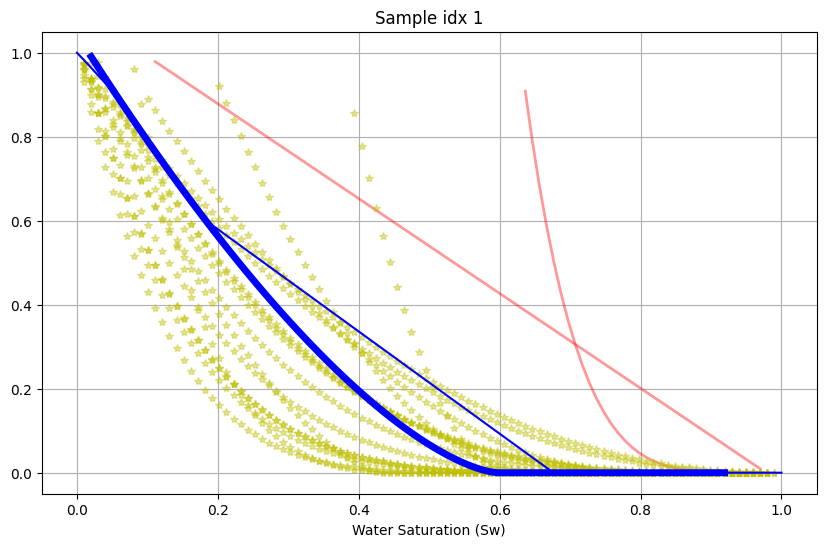

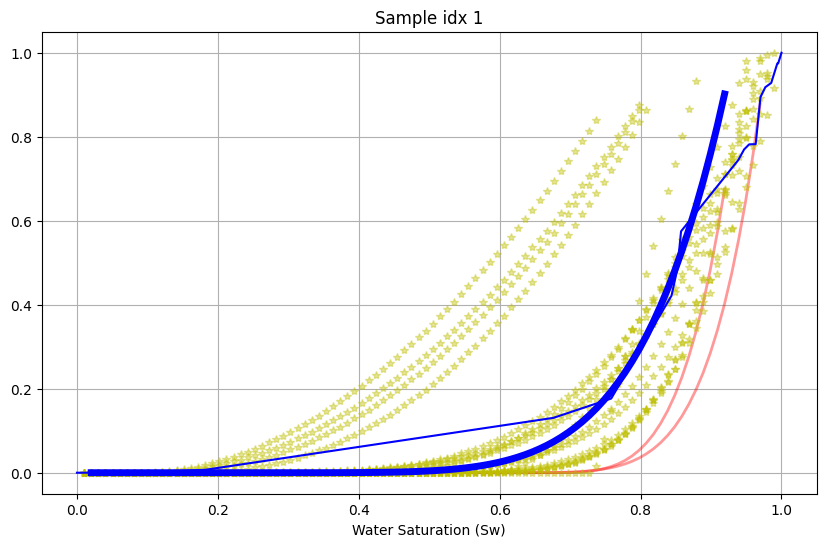

0.03500457324984029 0.0635500605689088


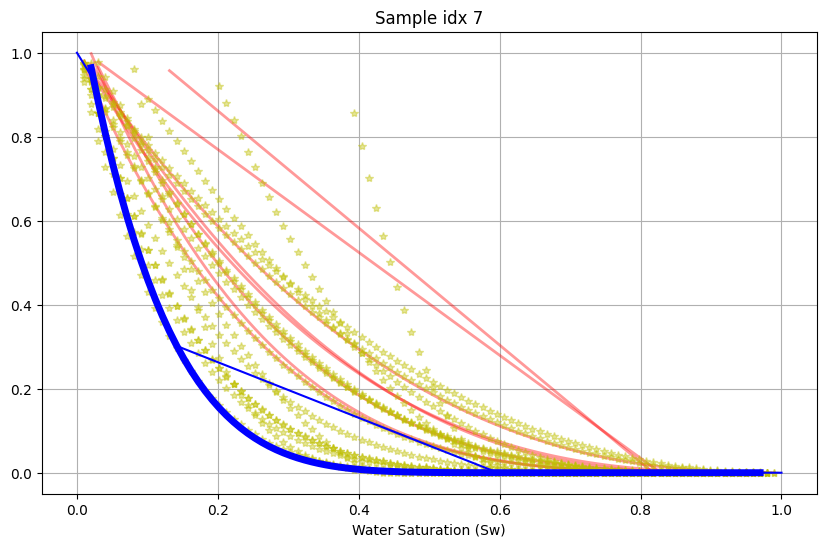

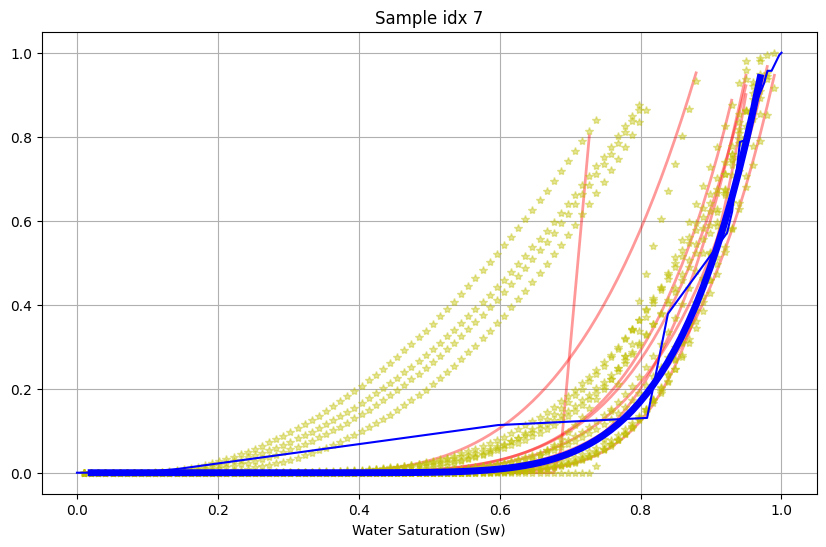

0.0855260996191125 0.08294851577931833


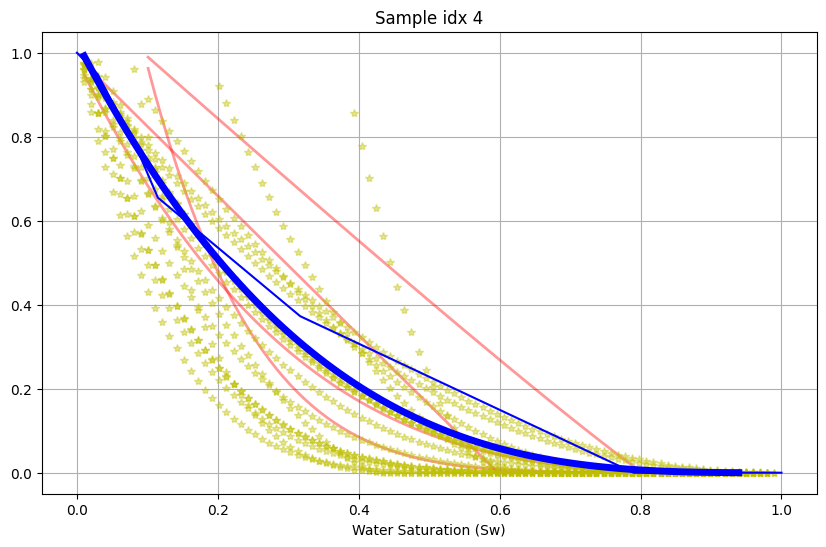

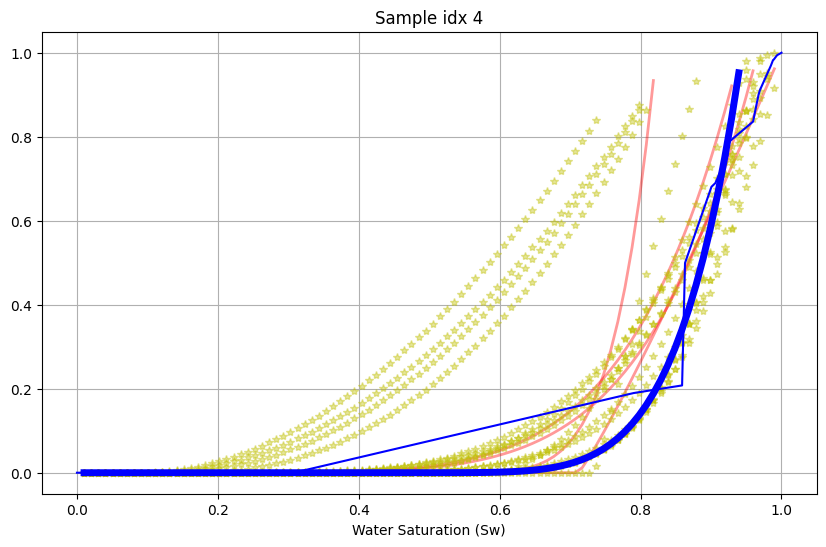

ct_idx 3
------------------------------------------------------------
0.01526651710771645 0.12403474437301382


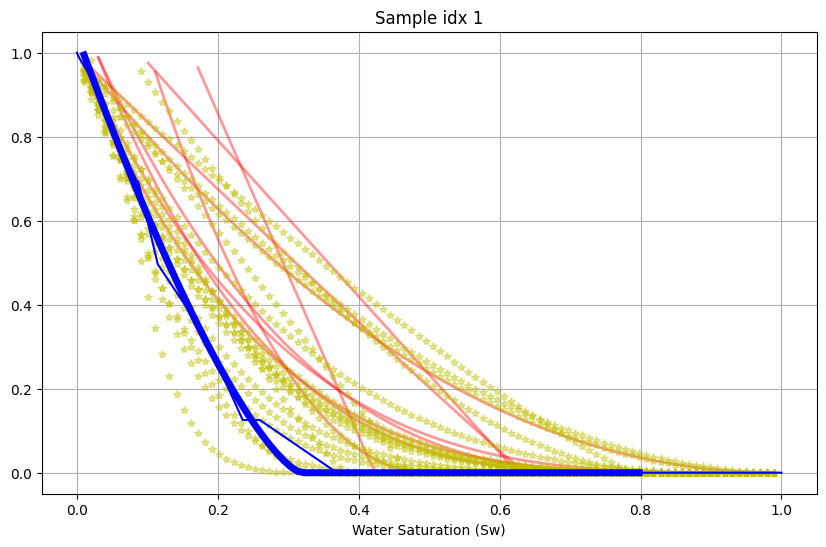

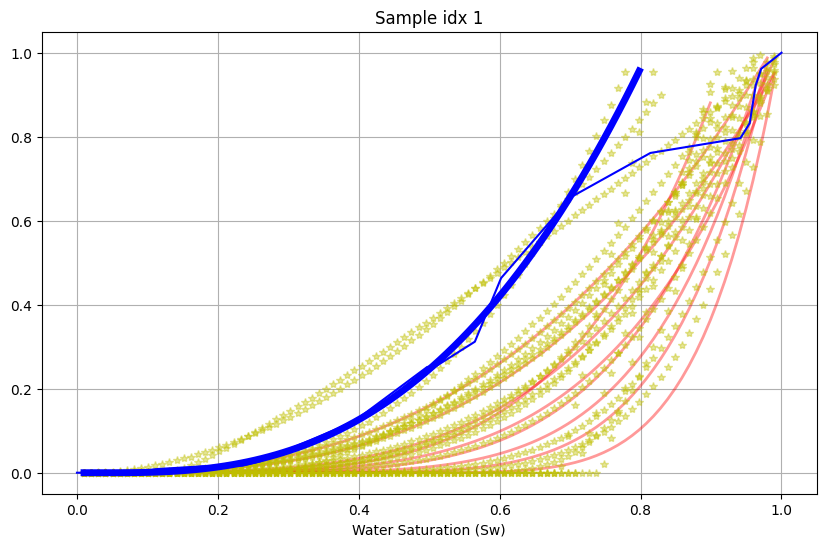

0.15279805338093888 0.25676444025106343


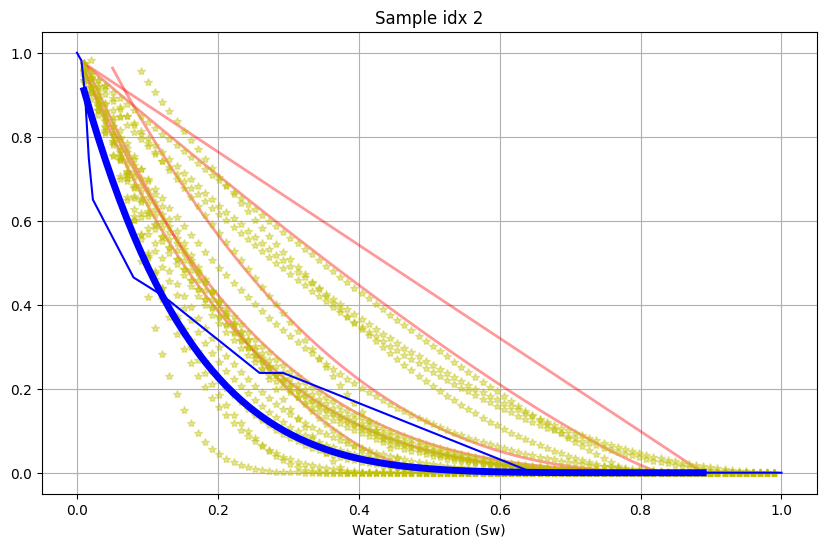

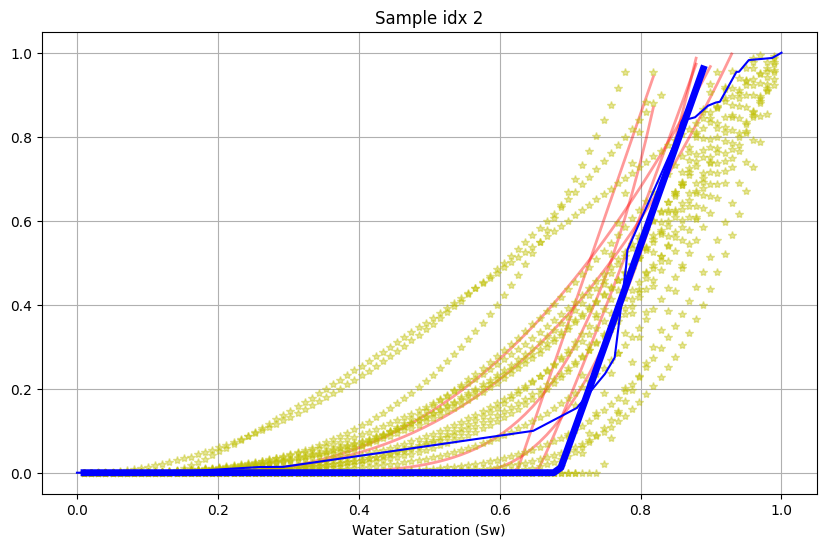

0.09259059200549707 0.10271303130420317


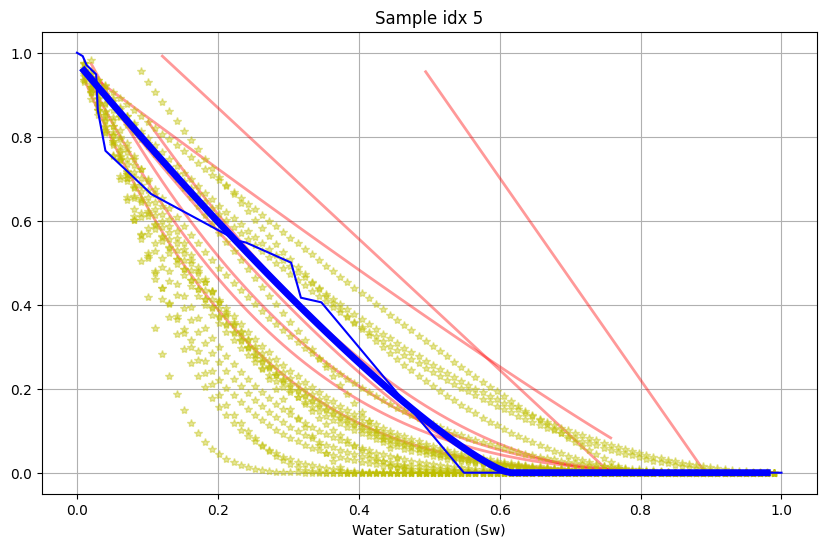

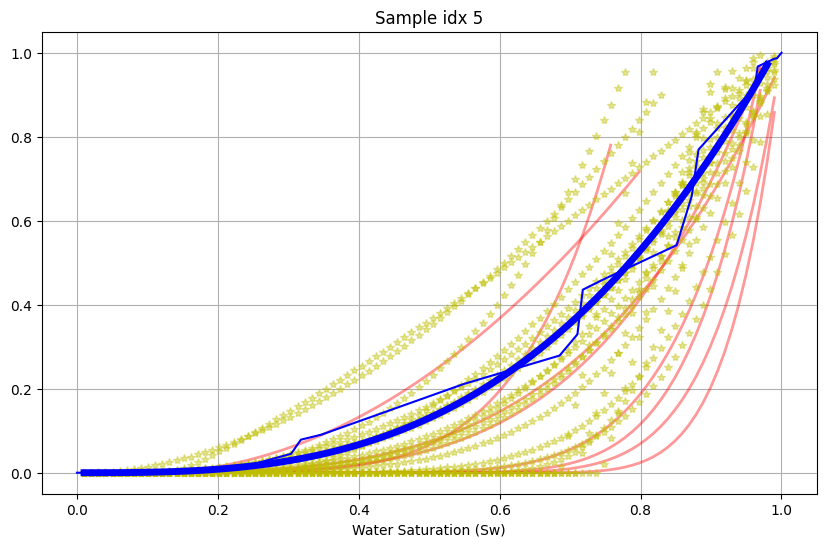

ct_idx 4
------------------------------------------------------------
0.0777525336906898 0.12035274280336317


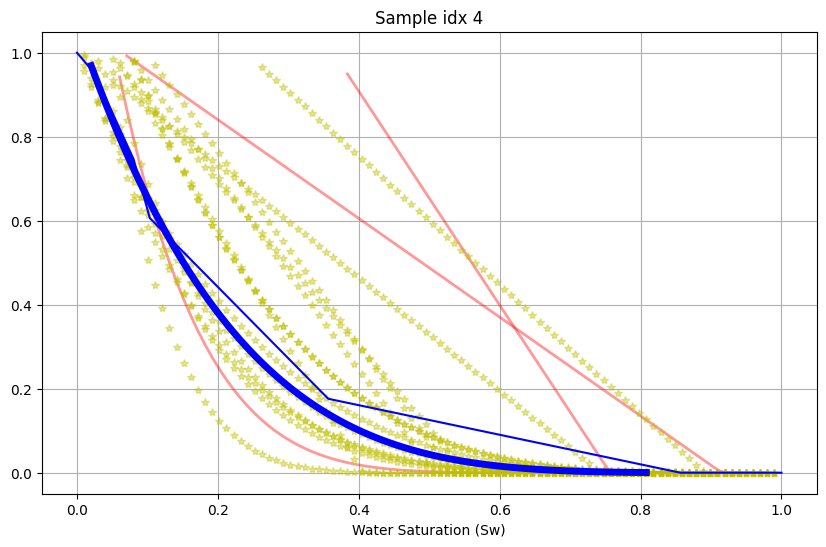

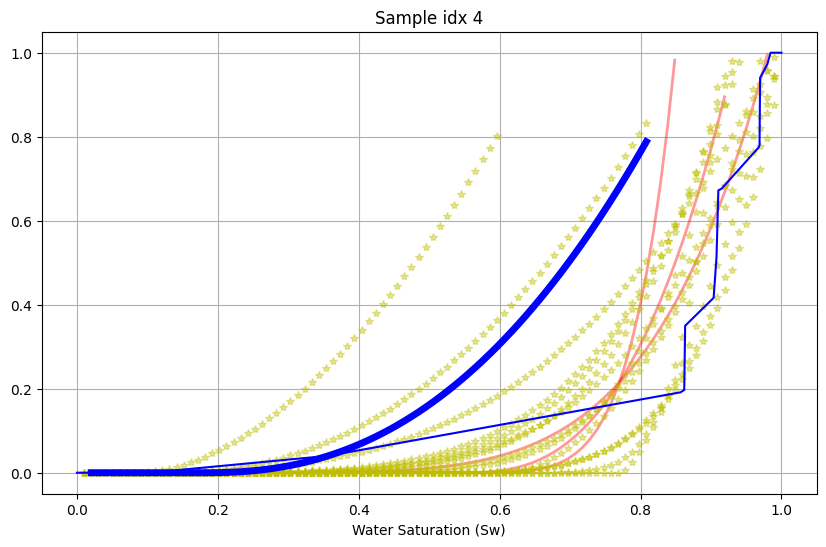

ct_idx 5
------------------------------------------------------------
0.08689679220305761 0.04999714698774732


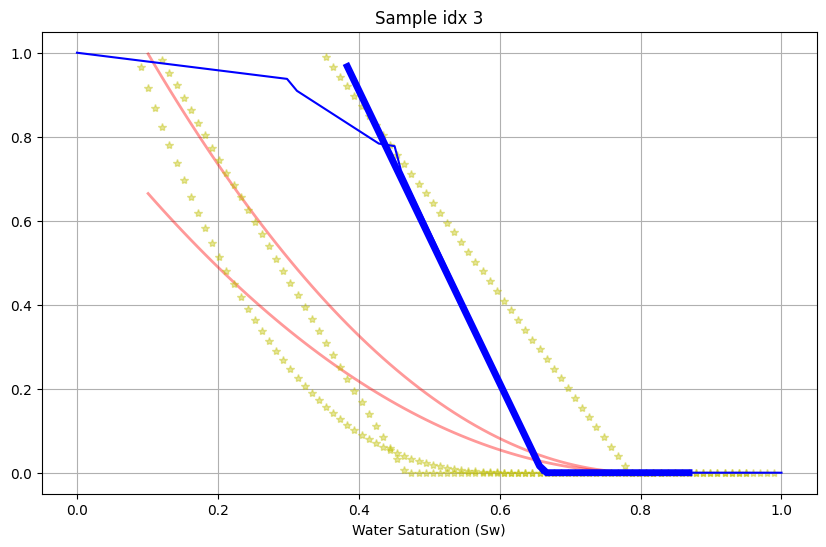

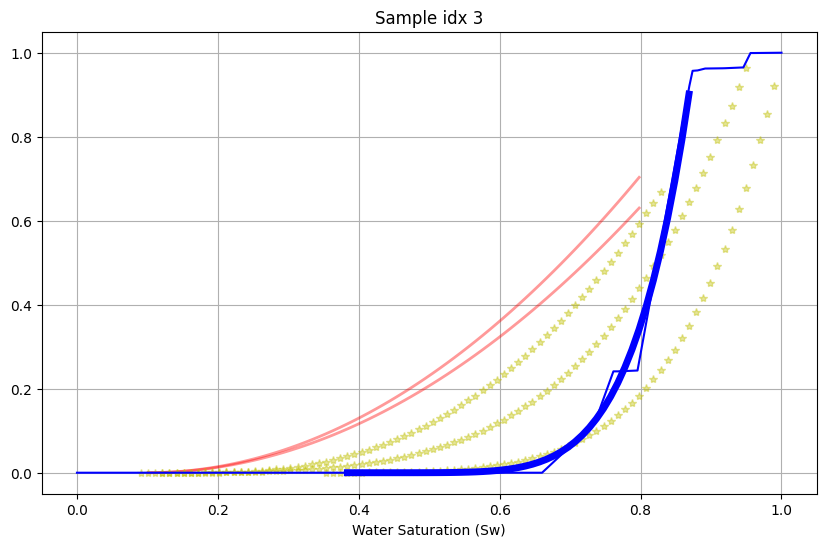

0.027280848504568227 0.00945446132297225


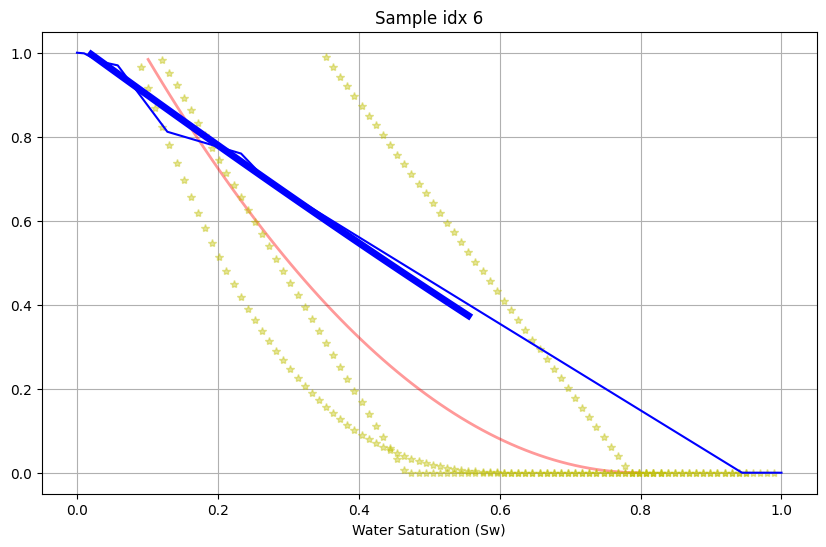

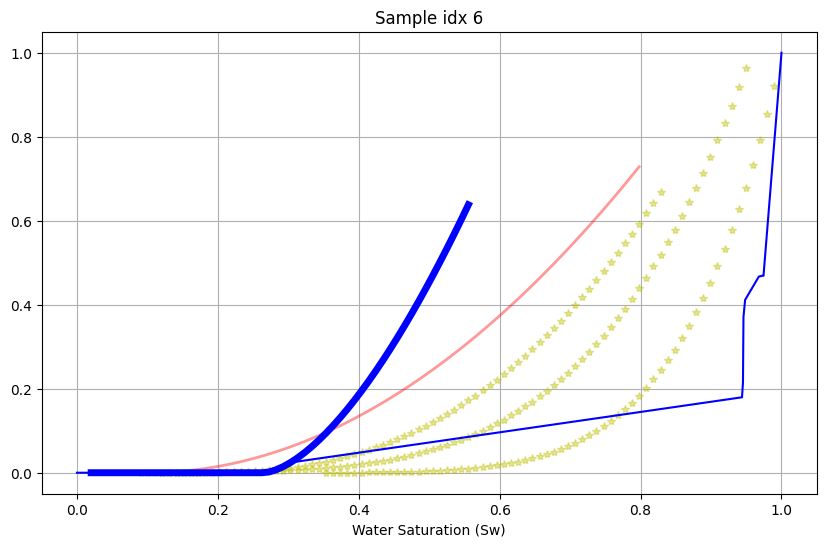

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [2]:
root_dir = 'db'
vol_dim = 4
import random

for ct_idx in range(1,6):

    with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
        # Deserialize the data from the file and assign it to a variable
        sim_results = pickle.load(file)

    
    print(f'ct_idx {ct_idx}')
    print(30*'--')

    indices = random.sample(range(0, 8), 4)
    for sample_idx in indices:

        plot_ensemble_results(sim_results, sample_idx, metric='mse')



# ct_idx = 2
# vol_dim = 3

# with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
#     # Deserialize the data from the file and assign it to a variable
#     sim_results = pickle.load(file)


# for sample_idx in [0,2,7,5]:
#     plot_ensemble_results(sim_results, sample_idx, metric='mse')




# ct_idx = 5
# vol_dim = 3

# with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
#     # Deserialize the data from the file and assign it to a variable
#     sim_results = pickle.load(file)


# for sample_idx in [0,2,7,5]:
#     plot_ensemble_results(sim_results, sample_idx, metric='mse')



In [13]:
def plot_ensemble_results_both(sim_results, sample_idx, metric='mse'):
    # df_all_compare = aggregate_kr(sim_results['compare'])
    num_pred = len(sim_results[sample_idx]['generate'])
    num_compare = len(sim_results['compare'])

    prediction = {'data':[],'par':[]}
    compare = {'data':[],'par':[]}



    for i in range(num_pred):
        if sim_results[sample_idx]['generate'][i]:
            df_pred = convert_dict_to_pd(sim_results[sample_idx]['generate'][i])
            corey_fit = Corey_fit(df_pred)
            kr_avg_pred,par,criteria = corey_fit.generate_kr_data()
            if criteria:
                prediction['data'].append(truncated_kr(kr_avg_pred,corey_fit))
                prediction['par'].append(par)
        


    for i in range(num_compare):
        if sim_results['compare'][i]:
            df_compare = convert_dict_to_pd(sim_results['compare'][i])
            corey_fit = Corey_fit(df_compare)
            kr_avg_compare,par,criteria = corey_fit.generate_kr_data()
            if criteria:
                compare['data'].append(truncated_kr(kr_avg_compare,corey_fit))
                compare['par'].append(par)

    df_real = sim_results[sample_idx]['original']
    if not df_real:
        return
    # fit the real data
    df_real = convert_dict_to_pd(df_real)
    corey_fit = Corey_fit(df_real)
    kr_real,par_real,criteria = corey_fit.generate_kr_data()

    if not criteria:
        return

    kr_real = truncated_kr(kr_real,corey_fit)


    prediction_data = prediction['data']
    compare_data = compare['data']
    num_samples = min(len(prediction_data), len(compare_data))
    irr_sw_pred = [x[0][1] for x in prediction['par']][:num_samples]
    irr_sw_compare = [x[0][1] for x in compare['par']][:num_samples]
    res_gas_pred = [x[1][1] for x in prediction['par']][:num_samples]
    res_gas_compare = [x[1][1] for x in compare['par']][:num_samples]


    from sklearn.metrics import mean_squared_error, mean_absolute_error
    # calculate error
    err_mse_swir_pred = calculate_error_metrics(
        irr_sw_pred,
        par_real[0][1], metric='mse'
        )
    err_mse_swir_compare = calculate_error_metrics(
        irr_sw_compare,
        par_real[0][1], metric='mse'
        )

    print(err_mse_swir_pred, err_mse_swir_compare)



    f = plt.figure(figsize=(10, 6))
    for i in range(len(prediction_data)):
        plt.plot(
            prediction_data[i]['sw'],
            prediction_data[i]['krnw'], 'r-*',
            linewidth=2,alpha=0.4
            )
        plt.plot(
            prediction_data[i]['sw'],
            prediction_data[i]['krw'], 'r-*',
            linewidth=2,alpha=0.4
            )
    
    for j in range(len(compare_data)):
        plt.plot(compare_data[j]['sw'],
                compare_data[j]['krnw'],
                'y*',
                linewidth=0.5,
                alpha=0.2
                )
        
        plt.plot(compare_data[j]['sw'],
                compare_data[j]['krw'],
                'y*',
                linewidth=0.5,
                alpha=0.2
                )
        
    plt.title(f'Sample idx {sample_idx}')
    plt.xlabel('Water Saturation (Sw)')
    plt.plot(kr_real['sw'], kr_real['krnw'], color='blue',linewidth=5)
    plt.scatter(df_real['sw'], df_real['kr_air'], color='blue')
    plt.plot(kr_real['sw'], kr_real['krw'], color='blue',linewidth=5)
    plt.scatter(df_real['sw'], df_real['kr_water'], color='blue')
    # plt.plot(df_real['sw'], df_real['kr_air'], color='blue')
    # plt.plot(df_real['sw'], df_real['kr_water'], color='blue')
    plt.grid(True)

    plt.show()

ct_idx 1
------------------------------------------------------------
1.2506436420525196e-33 0.00046989945421148333


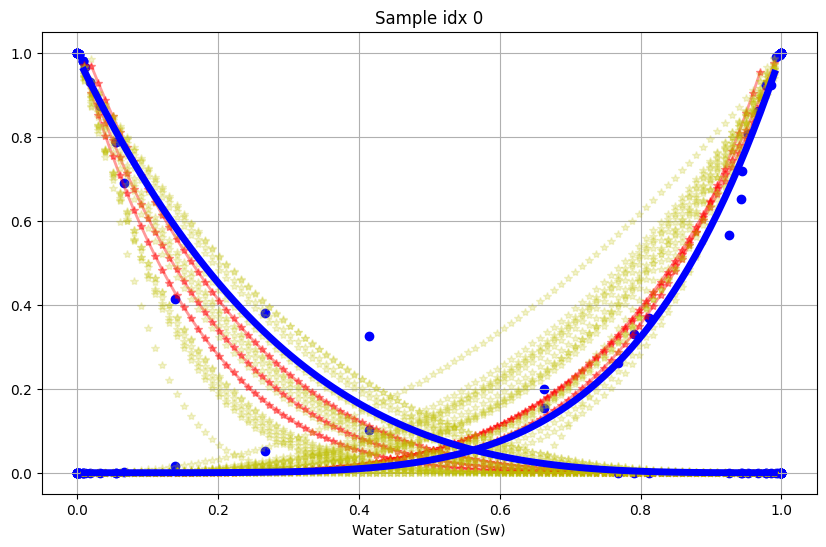

0.14346537774077503 0.00046989945421148333


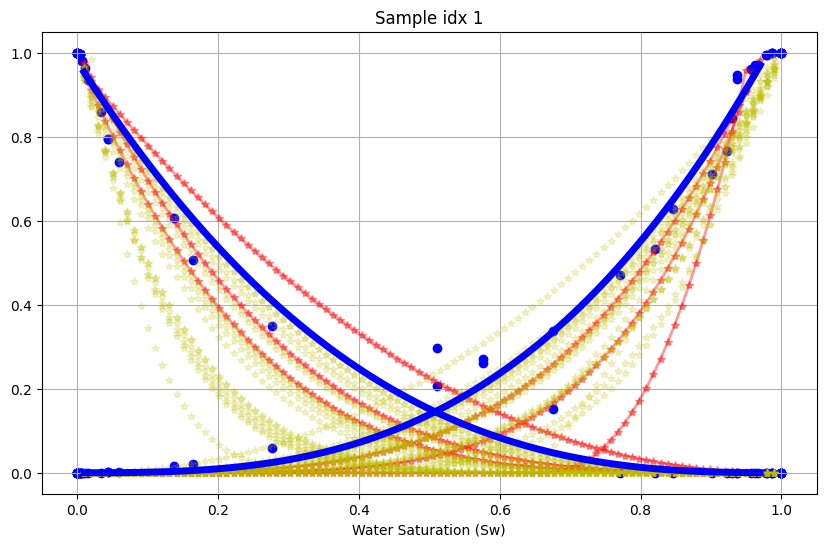

0.12617229820837747 0.00046989945421148333


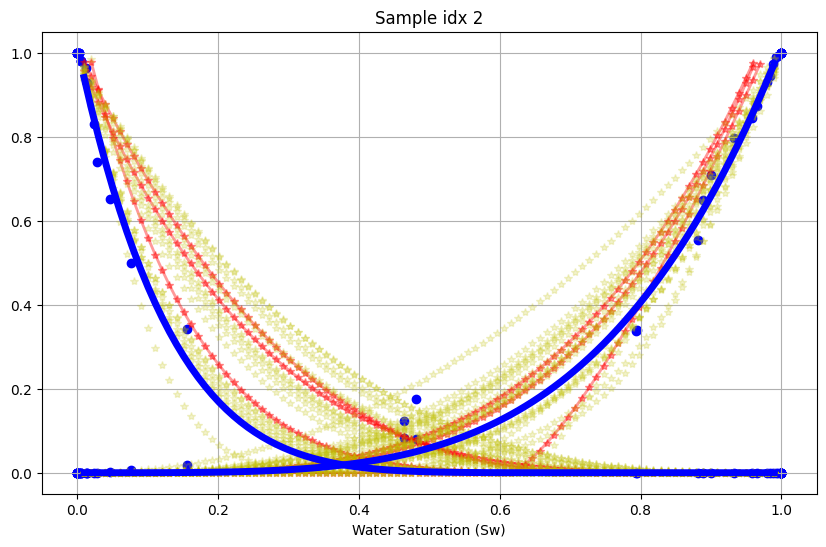

0.26911597956982997 0.013562280402097003


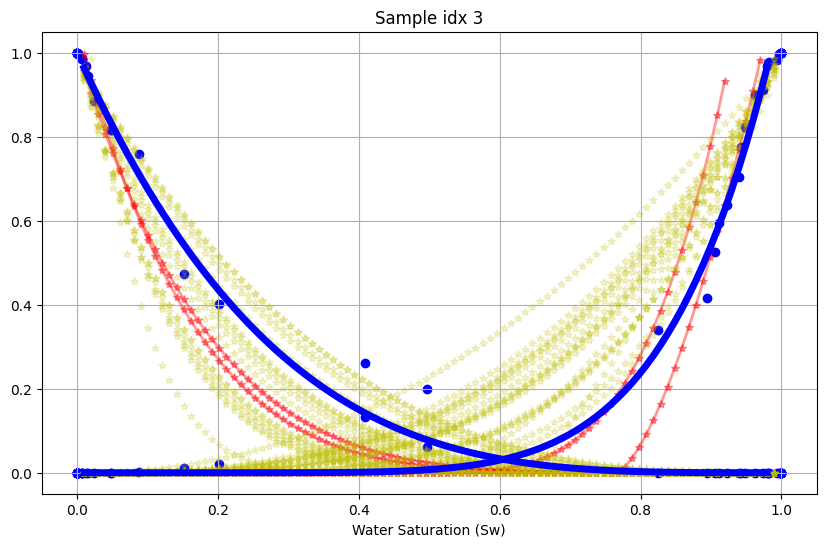

0.12907732587887658 0.0004698994542114109


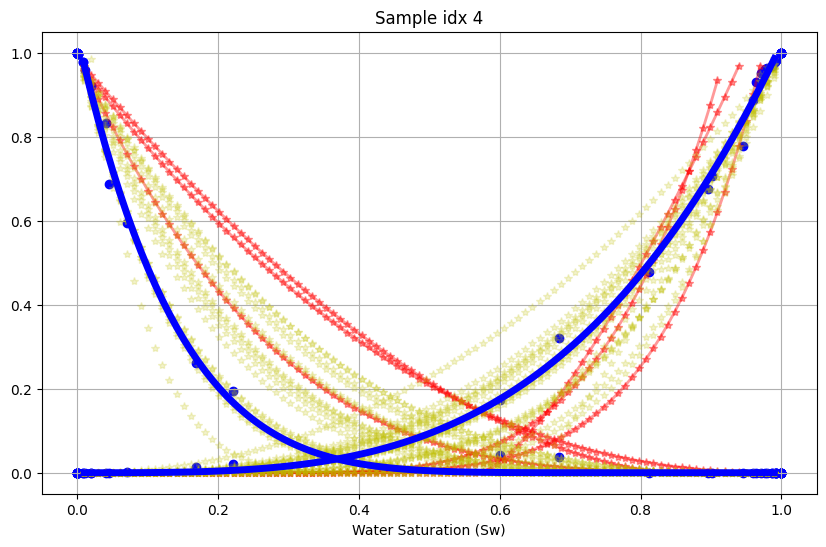

In [23]:
root_dir = 'db'
vol_dim = 6
ct_idx = 1



with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
    # Deserialize the data from the file and assign it to a variable
    sim_results = pickle.load(file)

    
print(f'ct_idx {ct_idx}')
print(30*'--')

indices = [0,1,2,3,4]
for sample_idx in indices:
    plot_ensemble_results_both(sim_results, sample_idx, metric='mse')

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (

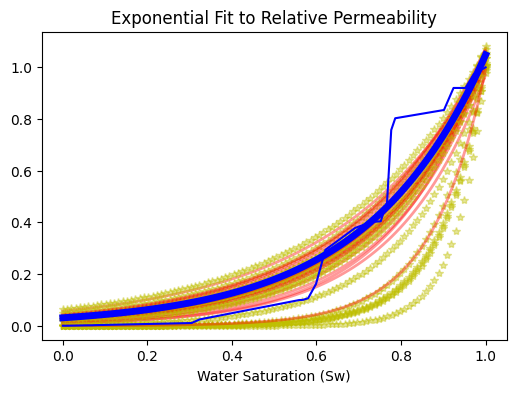

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn

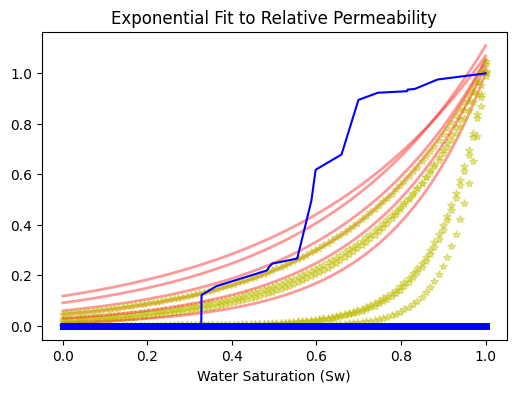

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be est

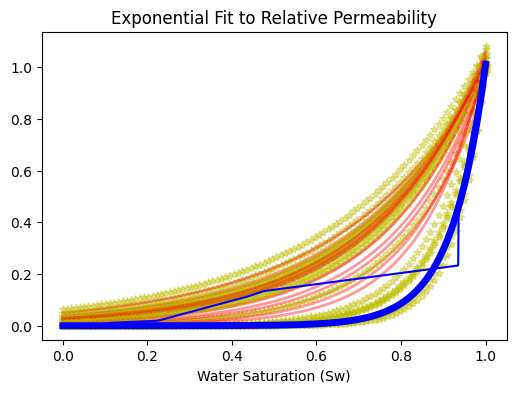

/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/pyt

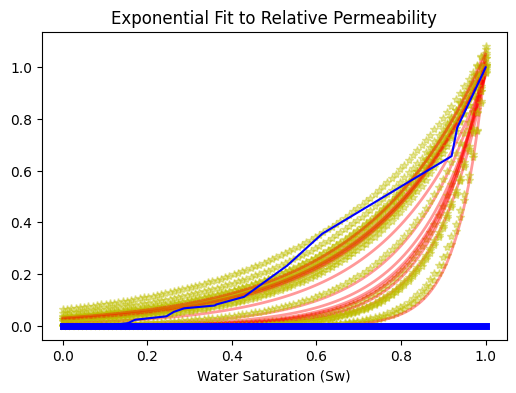

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn

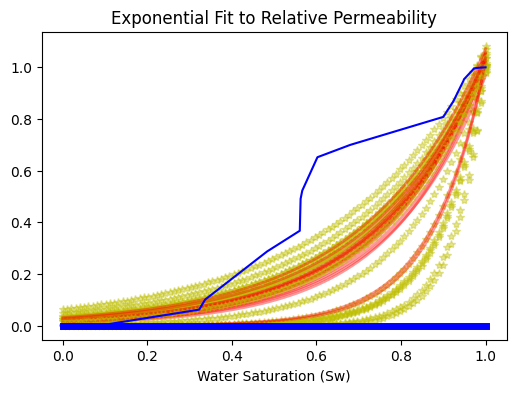

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (

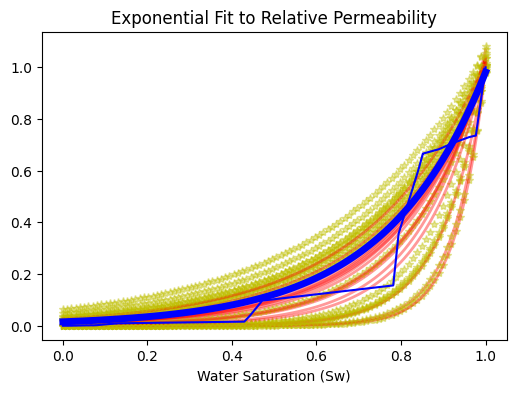

In [5]:
root_dir = 'db'
ct_idx = 3
vol_dim = 3
with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
    # Deserialize the data from the file and assign it to a variable
    sim_results = pickle.load(file)

for sample_idx in range(7):
    try:
        plot_sample(sample_idx)
    except:
        continue

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (

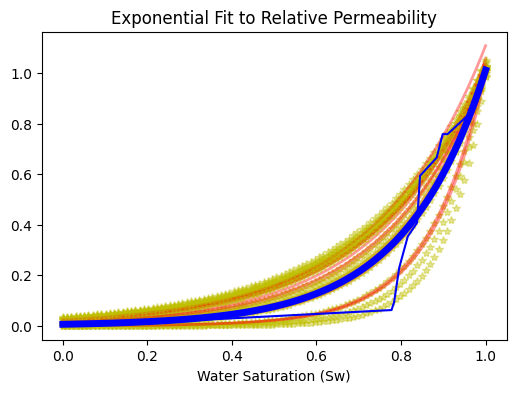

/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be est

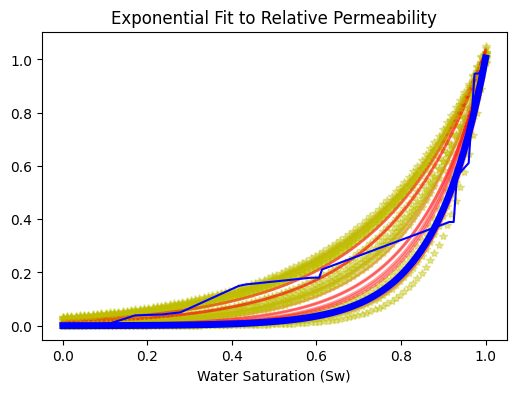

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn

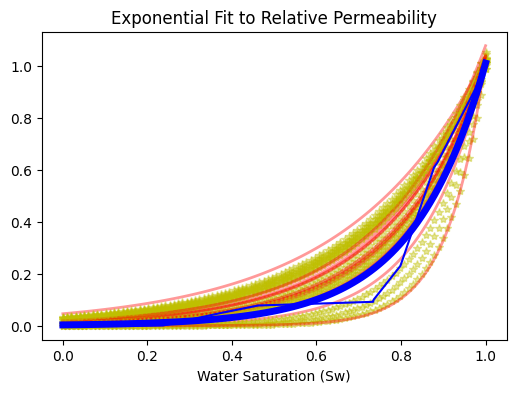

/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be est

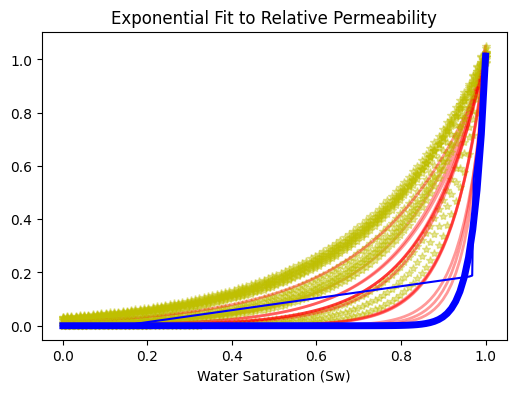

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (

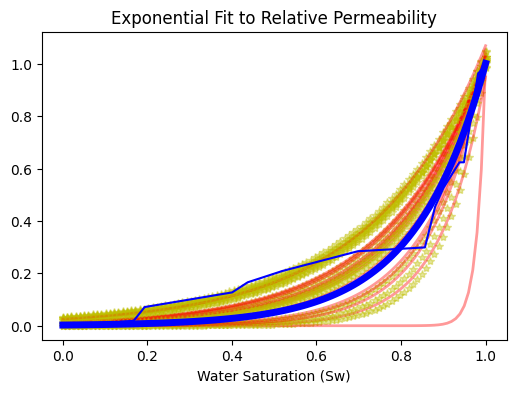

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn

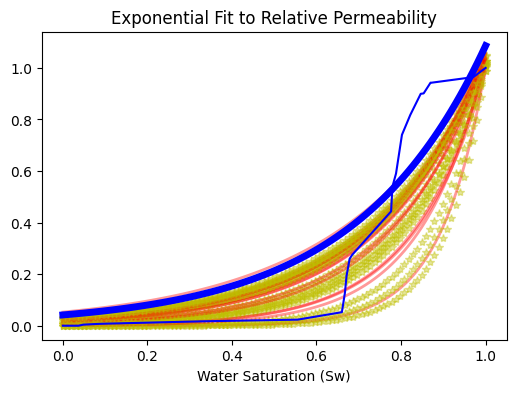

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (

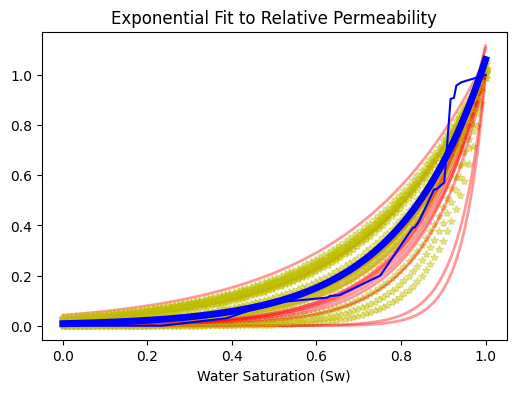

In [6]:
root_dir = 'db'
ct_idx = 1
vol_dim = 3
with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}.pickle', 'rb') as file:
    # Deserialize the data from the file and assign it to a variable
    sim_results = pickle.load(file)

for sample_idx in range(7):
    try:
        plot_sample(sample_idx)
    except:
        continue

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/journel/s0/zur74/LatentPoreUpscale3DNet/lpu3dnet/post_process/kr_process.py:26: RuntimeWarning: divide by zero encountered in true_divide
  return krnw0 * np.exp(-c * Sw / (1 - Sw))
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn

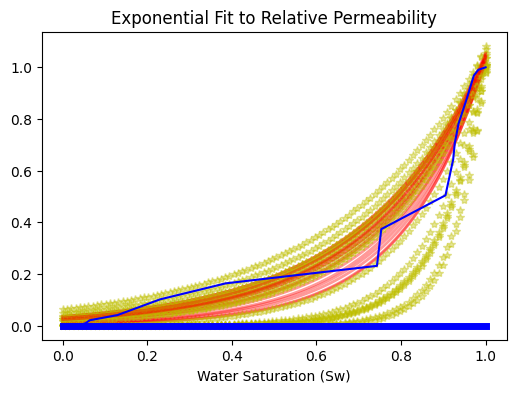

In [2]:
sample_idx = 7
# df_all_compare = aggregate_kr(sim_results['compare'])
num_pred = len(sim_results[sample_idx]['generate'])
num_compare = len(sim_results['compare'])

prediction = [] 
compare = []
for i in range(num_pred):
    df_pred = convert_dict_to_pd(sim_results[sample_idx]['generate'][i])
    exp_fit = Exponential_fit(df_pred)
    kr_avg_pred = exp_fit.generate_kr_data()
    if clean_df(kr_avg_pred):
        prediction.append(kr_avg_pred)
    


for i in range(num_compare):
    df_compare = convert_dict_to_pd(sim_results['compare'][i])
    exp_fit = Exponential_fit(df_compare)
    kr_avg_compare = exp_fit.generate_kr_data()
    if clean_df(kr_avg_compare):
        compare.append(kr_avg_compare)

df_real = sim_results[sample_idx]['original']
# fit the real data
df_real = convert_dict_to_pd(df_real)
exp_fit = Exponential_fit(df_real)
kr_real = exp_fit.generate_kr_data()


#%%
num_samples = min(len(prediction), len(compare))
f = plt.figure(figsize=(6, 4))
for i in range(num_samples):
    plt.plot(prediction[i]['sw'], prediction[i]['krw'], 'r-',linewidth=2,alpha=0.4)
    plt.plot(compare[i]['sw'], compare[i]['krw'], 'y*',linewidth=1,alpha=0.4)
    plt.title('Exponential Fit to Relative Permeability')
    plt.xlabel('Water Saturation (Sw)')
plt.plot(kr_real['sw'], kr_real['krw'], color='blue',linewidth=5, label='Actual Data')
plt.plot(df_real['sw'], df_real['kr_water'], color='blue', label='Actual Data')
plt.show()